In [1]:
import gc
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import utils.paths as plh
import category_encoders as ce
import matplotlib.pyplot as plt
import utils.read_utils as hlpread
from itertools import permutations, combinations

# Paths #

In [2]:
PROJECT_ROOT = plh.get_project_root()
PROJECT_ROOT

WindowsPath('F:/github_workspace/employee_access_resource_classifier')

In [5]:
train_data = os.path.join(PROJECT_ROOT, 
                          hlpread.read_yaml_key('data_source.data_folders'),
                          hlpread.read_yaml_key('data_source.prepared.folder'),
                          hlpread.read_yaml_key('data_source.prepared.clean_train'),
                        )
                        
train_data

'F:\\github_workspace\\employee_access_resource_classifier\\data\\prepared\\clean_train.csv'

In [6]:
train = hlpread.read_from_parquet(train_data)

print(train.shape)
train.head()

(30391, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [5]:
train.ACTION.value_counts()

1    28551
0     1840
Name: ACTION, dtype: int64

# Exploratory Data Analysis (EDA) #

  - "RESOURCE" feature should be consider with all other feature. Since "ACCESS" to any thing is based on the "RESOURCE" itself.

### Feature: "RESOURCE" and "ACTION" ###
* Distribution of "ACCESS" action per "RESOURCE".</br>
    Are there "RESOURCE" that all the employee/role have access to ? i.e there are no negative class label for the "RESOURCE"

In [8]:
#train[["RESOURCE","ACTION"]].value_counts().reset_index(name = "COUNT")#.sort_values(by = "RESOURCE").plot(x = "COUNT",  y="RESOURCE",  color='darkblue')
temp_x = pd.crosstab(train['RESOURCE'], train['ACTION']).reset_index().sort_values(by = [0,1])
temp_x.rename_axis(None, axis = 1, inplace = True)

In [17]:
temp_x

,RESOURCE,0,1
2,136,0,1
5,199,0,1
8,233,0,1
14,674,0,1
16,677,0,1
...,...,...,...
1465,27416,19,18
1329,25993,19,361
326,13878,20,161
674,18072,28,87


In [13]:
temp_x[temp_x[0] == 0].RESOURCE.count()

6384

In [14]:
temp_x[temp_x[1] == 0].RESOURCE.count()

292

In [18]:
#Plot was not clearly visible
#fig = plt.figure(num = 1, 
#                 figsize = (25,10), 
#                 dpi = 200, 
#                 clear = True,
#                 constrained_layout =  True)
#ax = temp_x.plot(kind = 'bar', stacked = True, color = ['steelblue', 'red'], mark_right = True)
#fig.show()

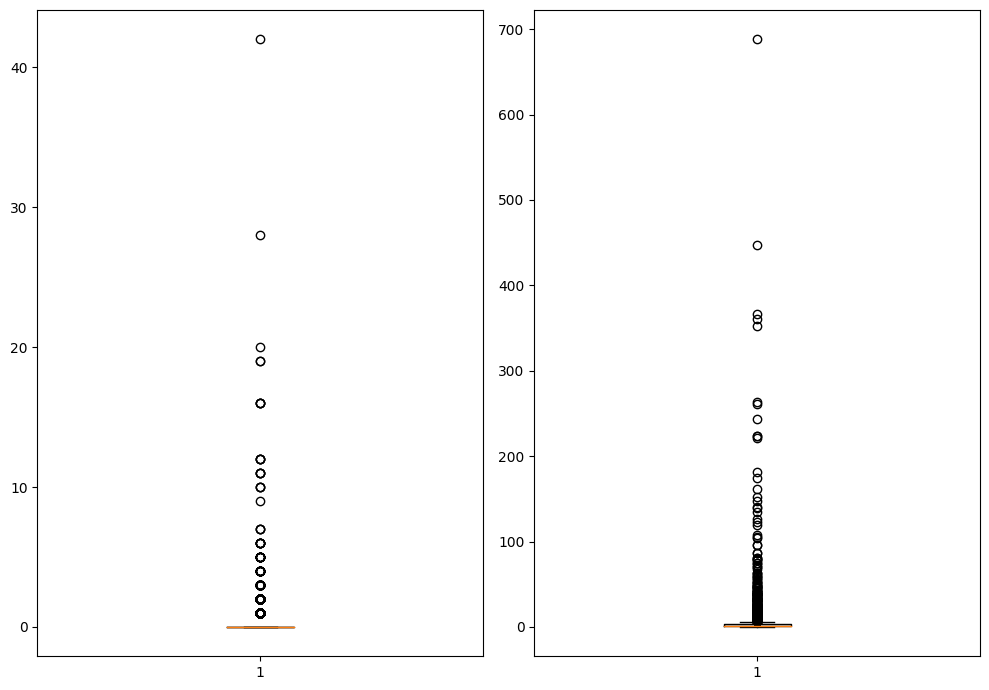

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize =(10, 7), tight_layout = True)
ax1.boxplot(temp_x[0])
ax2.boxplot(temp_x[1])
plt.show()

<AxesSubplot:xlabel='0', ylabel='Count'>

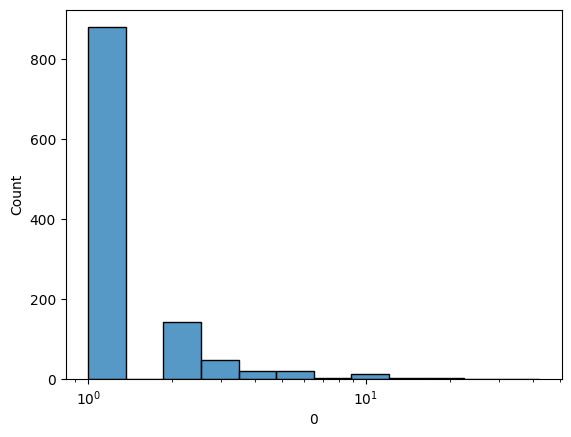

In [58]:
#fig = plt.figure(figsize = (10,5))
#binwidth = 1
#plt.hist(temp_x[0], bins = range(min(temp_x[0]), max(temp_x[0]) + binwidth, binwidth))
#plt.show()
#Data heavily skewed distributions, it’s better to define the bins used log space.
#Since log of 0 is error. Lets filter out records with 0. In our case 0 is no records belong to that class label
sns.histplot(temp_x[temp_x[0]>0][0],  log_scale = True)

<AxesSubplot:xlabel='1', ylabel='Count'>

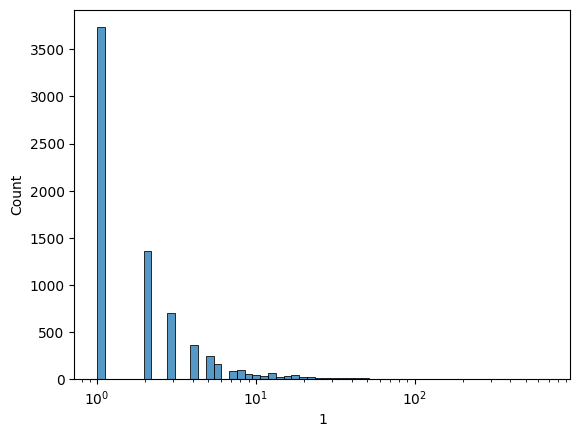

In [59]:
sns.histplot(temp_x[temp_x[1]>0][1],  log_scale = True)

#### Observation: ####

* There are resource where there are no -ve class label. </br>
    Can we say that those RESOURCE are always assign to all employee or we do not have enough sample for those RESOURCE?
    -  Unique number of records for RESOURCE: 7518
    - RESOURCE with no -ve class label: 6384
    - RESOURCE with no +ve class label: 292
    - So approx 11% ( (7518 - ( 6384 + 292)) /7518 ) of RESOURCE have both class data for classification and remaining approx 89% data points have either of one type of class labels.

For futher analysis let add a feature column that will help use to identify if the RESOURCE has all the data point belong to one type of class lable, 50-50 class labels or other.

In [11]:
train['ONLY_SINGLE_EQUAL_DATA_POINTS'] = 0 #np.nan
#Label 1 for Single data points for either of label
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[1]==1) & (temp_x[0]==0)].RESOURCE)].index,'ONLY_SINGLE_EQUAL_DATA_POINTS'] = 1
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[0]==1) & (temp_x[1]==0)].RESOURCE)].index,'ONLY_SINGLE_EQUAL_DATA_POINTS'] = 1

#Label 2 for Equal data points of both label
train.loc[train[train.RESOURCE.isin(temp_x[temp_x[0]== temp_x[1]].RESOURCE)].index,'ONLY_SINGLE_EQUAL_DATA_POINTS'] = 2

#For rest Label 0
#train.ONLY_SINGLE_EQUAL_DATA_POINTS.fillna(0, inplace = True)

#Label if we have only positive class label
train['IS_ONLY_POS_LABEL'] = 0
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[0]==0)].RESOURCE)].index,'IS_ONLY_POS_LABEL'] = 1

#Label if we have only negative class label
train['IS_ONLY_NEG_LABEL'] = 0
train.loc[train[train.RESOURCE.isin(temp_x[(temp_x[1]==0)].RESOURCE)].index,'IS_ONLY_NEG_LABEL'] = 1

print('='*20)
print(train.ONLY_SINGLE_EQUAL_DATA_POINTS.value_counts())
print('='*20)
print(train.IS_ONLY_POS_LABEL.value_counts())
print('='*20)
print(train.IS_ONLY_NEG_LABEL.value_counts())
#print('='*20)

0    26173
1     3817
2      406
Name: ONLY_SINGLE_EQUAL_DATA_POINTS, dtype: int64
0    15333
1    15063
Name: IS_ONLY_POS_LABEL, dtype: int64
0    30075
1      321
Name: IS_ONLY_NEG_LABEL, dtype: int64


In [23]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ONLY_SINGLE_EQUAL_DATA_POINTS,IS_ONLY_POS_LABEL,IS_ONLY_NEG_LABEL
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,0,1,0
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,0,0,0
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,0,1,0
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,1,1,0
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,0,1,0


In [ ]:
#Based on our previous analysis there are only 11% "RESOURCE" that have some distrubution between +ve and -ve labels based on there ROLE features
#Will filter them out for futher analysis

#list_resource_with_has_only_one_type_label = np.append(temp_x[temp_x[1] == 0].RESOURCE.values,  #Filter out "RESOURCE" where there are no +ve class label
#                                                       temp_x[temp_x[0] == 0].RESOURCE.values,  #Filter out "RESOURCE" where there are no -ve class label
#                                                       axis = 0
#                                                      )

In [12]:
del [temp_x]
gc.collect()

63

#### Observation: ####
* 15384 resource data points have only one type of class label. So we do not have enought -ve or +ve class label.
* of 15384 we have 4223 data points that either +ve or -ve class.
In both the case we do not have enought data points to generalize those data point.

***Note:*** On futher thought it make sence that there are RESOURCE with no -ve class label.</br>
**e.g** in case of Software Developer and Support Enginer Role there are some set of RESOURCE that are only require the role the employee. i.e IDE is not need to Support Enginer role like wise is the case of Support Enginer.</br>
So there are many RESOURCE with no -ve class label. -ve class sample make sense only if the resource of particular role need to be segreated. e.g Resource_1 and Resource_2 belong to Suport Engineer Role, but only Resource_1 is assigned to employee with Role1.

### Feature : ROLE_TITLE AND ROLE_CODE ###

In [11]:
col1 = 'ROLE_CODE'
col2 = 'ROLE_TITLE'

pair = len(train.groupby([col1,col2]).size())
single = len(train.groupby([col1]).size())

print(col1, col2, pair, single)

ROLE_CODE ROLE_TITLE 343 343


In [87]:
# Number of unique ROLES feature per RESOURCE. 
# But counting the number of unique value for each feature will give idea the details we get from the role feature for the given resource. 
# i.e various combination of role feature to identify "RESOURCE" and the "ACTION"

temp_out = (train[['ACTION', 'RESOURCE', 
                   'ROLE_TITLE', 'ROLE_CODE']]
             .drop_duplicates()
             .groupby(by = ['RESOURCE'])
             .agg(
                  COUNT_ROLE_TITLE_PER_RESOURCE = ('ROLE_TITLE', 'nunique'),                  
                  COUNT_ROLE_CODE_PER_RESOURCE = ('ROLE_CODE', 'nunique'),
                 )
             .reset_index()
             .sort_values(by = [
                                'COUNT_ROLE_TITLE_PER_RESOURCE',                               
                                'COUNT_ROLE_CODE_PER_RESOURCE'
                               ])
            )

temp_out

,RESOURCE,COUNT_ROLE_TITLE_PER_RESOURCE,COUNT_ROLE_CODE_PER_RESOURCE
2,136,1,1
5,199,1,1
8,233,1,1
12,667,1,1
14,674,1,1
...,...,...,...
1987,32270,83,83
4936,75078,89,89
182,3853,92,92
1329,25993,108,108


In [88]:
#ROLE_TITLE and ROLE_CODE seem to have same number of unique count. Lets check if we can us either one.
temp_out[['RESOURCE','COUNT_ROLE_TITLE_PER_RESOURCE','COUNT_ROLE_CODE_PER_RESOURCE']]

,RESOURCE,COUNT_ROLE_TITLE_PER_RESOURCE,COUNT_ROLE_CODE_PER_RESOURCE
2,136,1,1
5,199,1,1
8,233,1,1
12,667,1,1
14,674,1,1
...,...,...,...
1987,32270,83,83
4936,75078,89,89
182,3853,92,92
1329,25993,108,108


In [89]:
train[train.RESOURCE == 33642].sort_values(by = ['ROLE_TITLE','ROLE_CODE'])

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ONLY_SINGLE_EQUAL_DATA_POINTS,IS_ONLY_POS_LABEL,IS_ONLY_NEG_LABEL
59,1,33642,13196,117951,117952,117941,117879,117897,19721,117880,0,0,0
812,1,33642,80413,118163,118164,117878,117879,117879,19721,117880,0,0,0
1245,1,33642,275544,117876,117877,117878,117879,117879,19721,117880,0,0,0
2278,1,33642,27484,118185,31010,117941,117879,117886,19721,117880,0,0,0
2324,1,33642,21083,118106,118107,117941,117879,117886,19721,117880,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,0,33642,6982,117961,118300,118783,118784,213944,290919,118786,0,0,0
1484,1,33642,53247,117932,117933,117878,119786,119787,119788,119789,0,0,0
24678,1,33642,46514,117961,118300,120059,119849,310589,118638,119851,0,0,0
13753,1,33642,7459,5110,117954,122672,125751,135104,118870,125753,0,0,0


In [90]:
del [temp_out]
gc.collect()

345

#### Observation: #### 

It seems like these 2 columns have 1:1 relationship. For each unique value in column ROLE_CODE there is 1 and only 1 unique value in column ROLE_TITLE. In other words we don't need both columns to build a model, so I'm removing ROLE_TITLE.

### Are there any similiarity in the ROLE's feature for these RESOURCE ? ###

In [94]:
print('Number of records with same ROLE\'s feature but different RESOURCE\'s')
dup = train.duplicated(subset = ['ACTION','ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'])
dup.value_counts()

Number of records with same ROLE's feature but different RESOURCE's


True     23300
False     7096
dtype: int64

**Note:** </br>
When using 'ACTION' when calculate duplicate</br>
**o/p:**</br>
True     23300</br>
False     7096</br>

When using without 'ACTION' when calculate duplicate</br>
**o/p:**</br>
True     23974</br>
False     6422</br>


In [92]:
train[dup].sort_values(by = ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE'])

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,ONLY_SINGLE_EQUAL_DATA_POINTS,IS_ONLY_POS_LABEL,IS_ONLY_NEG_LABEL
4229,1,34628,2199,4292,124335,118378,128093,300603,119184,128095,0,0,0
6754,1,15739,2199,4292,124335,118378,128093,300603,119184,128095,0,1,0
31010,1,78507,2199,4292,124335,118378,128093,300603,119184,128095,1,1,0
4543,1,15739,2199,4292,126095,118378,179731,179731,117887,117973,0,1,0
13233,1,25098,2199,4292,126095,118378,179731,179731,117887,117973,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29352,1,278393,33266,216705,119256,129526,119849,160290,118638,119851,0,0,0
32273,1,34345,33266,216705,119256,129526,119849,160290,118638,119851,0,0,0
24822,1,78955,80413,247952,118164,117878,117885,117879,117887,117888,1,1,0
30833,1,59761,83254,247952,118164,117878,117885,117879,117887,117888,0,1,0


##### Observation: #####

- We have 23300 where we have same ROLE's feature but different RESOURCE with same ACTION. This proof that multiple RESOURCE that are assign to employee of same ROLE's. </br>
- We can create a new feature by various combine of 'ROLE_ROLLUP_1' + 'ROLE_ROLLUP_2' + 'ROLE_DEPTNAME' + 'ROLE_FAMILY_DESC' + 'ROLE_FAMILY' + 'ROLE_CODE' and encode RESOURCE using the new combined features.</br>
    **Idea:** to group RESOURCE that are related to certain ROLE's. This will act as filter between the RESOURCE required for each ROLE's
    e.g Developer will need access to RESOURCE that are relevent to code development.
        But HR will not need access to those RESOURCES.

### Feature: ROLE_ROLLUP_1 and ROLE_ROLLUP_2 ###

Analysis with both type of "RESOURCE" distrubution(i.e single and more the one sample per RESOURCE)

In [15]:
grp_role_rollup_2 = (train.groupby(['RESOURCE','ROLE_ROLLUP_2']).agg(target_mean =  ('ACTION','mean'), 
                                                                     target_count = ('ACTION','count')
                                                                     )
                                                                     .reset_index()
                                                                     .sort_values(by = ['RESOURCE','target_mean'], ascending = True))
#grp_role_rollup_2
display(grp_role_rollup_2[grp_role_rollup_2.RESOURCE.isin([0,153])])
print('='*50)
display(grp_role_rollup_2[(grp_role_rollup_2.target_mean != 0.0) & (grp_role_rollup_2.target_mean != 1.0)])

,RESOURCE,ROLE_ROLLUP_2,target_mean,target_count
0,0,118386,0.0,1
1,0,118413,1.0,12
9,153,117962,0.0,1
10,153,118386,0.0,1
8,153,117903,1.0,1
11,153,118413,1.0,10


,RESOURCE,ROLE_ROLLUP_2,target_mean,target_count
26,391,118124,0.888889,18
61,710,117962,0.500000,2
62,710,118327,0.500000,2
87,838,118052,0.500000,2
110,915,120865,0.500000,2
...,...,...,...,...
13355,278393,118052,0.800000,10
13362,278393,118300,0.925926,54
13386,302049,119070,0.333333,3
13382,302049,118170,0.600000,5


In [16]:
# Number of "RESOURCE" each "ROLE_ROLLUP_2" define them
(train.groupby(["ROLE_ROLLUP_2"]).agg(target_count = ('RESOURCE','count'))
                                 .reset_index()
                                 .sort_values(by = ['target_count'], ascending = False))

,ROLE_ROLLUP_2,target_count
64,118300,4238
68,118343,3631
66,118327,2490
58,118225,2381
71,118386,1697
...,...,...
142,121602,1
132,120355,1
110,119344,1
127,120018,1


#### Observartion: ####

 * Number of sample resource count per roles "ROLE_ROLLUP_1" looks better.
    - "ROLE_ROLLUP_1": 128
    - "ROLE_ROLLUP_2": 177
* Number of records individual feature are not able to clearly classify:
    - "ROLE_ROLLUP_1": 863
    - "ROLE_ROLLUP_2": 720
 * "ROLE_ROLLUP_2" feature alone is able to better clasify number of +ve and -ve sample compare to "ROLE_ROLLUP_1" access of the "RESOURCE".
 * There are "RESOURCE" where "ROLE_ROLLUP_1" is able to clasify better for +ve sample "ROLE_ROLLUP_2" </br>
   e.g </br>
   "ROLL_ROLLUP_1" work better: RESOURCE: 278393, ROLE_ROLLUP_1:118300</br>
   "ROLL_ROLLUP_1" work better: RESOURCE: 278393, ROLE_ROLLUP_1:118300 </br>

In [19]:
te = train[(train.IS_ONLY_POS_LABEL==1) | (train.IS_ONLY_NEG_LABEL==1)].groupby(['ROLE_ROLLUP_1','ROLE_ROLLUP_2']).size().reset_index()
te.columns = ['ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'size_cnt']
te['single_role_rollup_1'] = te.duplicated(subset = ['ROLE_ROLLUP_1'])

print('Value counts of single_role_rollup_1')
print(te.single_role_rollup_1.value_counts())
print('='*50)
te

Value counts of single_role_rollup_1
False    118
True      54
Name: single_role_rollup_1, dtype: int64


,ROLE_ROLLUP_1,ROLE_ROLLUP_2,size_cnt,single_role_rollup_1
0,4292,124335,4,False
1,4292,126095,7,True
2,5110,117954,141,False
3,11146,118491,12,False
4,91261,118026,399,False
...,...,...,...,...
167,183723,119256,2,False
168,192441,141176,1,False
169,216705,119256,4,False
170,247952,118164,9,False


In [20]:
te[te.single_role_rollup_1]

,ROLE_ROLLUP_1,ROLE_ROLLUP_2,size_cnt,single_role_rollup_1
1,4292,126095,7,True
8,117887,119256,3,True
9,117887,120846,3,True
10,117887,124157,2,True
11,117887,176316,1,True
13,117890,118102,49,True
16,117902,118041,85,True
18,117910,118855,10,True
20,117916,118011,55,True
21,117916,118150,51,True


In [21]:
te = train[(train.IS_ONLY_POS_LABEL==1) | (train.IS_ONLY_NEG_LABEL==1)].groupby(['ROLE_ROLLUP_2', 'ROLE_ROLLUP_1']).size().reset_index()
te.columns = [ 'ROLE_ROLLUP_2', 'ROLE_ROLLUP_1','size_cnt']
te['single_role_rollup_2'] = te.duplicated(subset = ['ROLE_ROLLUP_2'])

print('Value counts of single_role_rollup_2')
print(te.single_role_rollup_2.value_counts())
print('='*50)
te

Value counts of single_role_rollup_2
False    165
True       7
Name: single_role_rollup_2, dtype: int64


,ROLE_ROLLUP_2,ROLE_ROLLUP_1,size_cnt,single_role_rollup_2
0,23779,118074,15,False
1,31010,118185,9,False
2,32137,133430,1,False
3,117877,117876,81,False
4,117883,117882,9,False
...,...,...,...,...
167,145248,132839,6,False
168,151110,121005,5,False
169,159716,118212,7,False
170,176316,117887,1,False


In [22]:
te[te.single_role_rollup_2]

,ROLE_ROLLUP_2,ROLE_ROLLUP_1,size_cnt,single_role_rollup_2
50,118164,247952,9,True
53,118178,118555,40,True
109,119256,117961,16,True
110,119256,130570,9,True
111,119256,183723,2,True
112,119256,216705,4,True
113,119256,311178,2,True


#### Observartion: ####

* Only 54 records where RESOURCE need to be classified by combining ROLE_ROLLUP_1 and ROLE_ROLLUP_2 values.
* Only 7 records where RESOURCE need to be  classified by combining  ROLE_ROLLUP_2 and ROLE_ROLLUP_1 values.
*  Case there is 1:1 relation between ROLE_ROLLUP_2 and ROLE_ROLLUP_1 i.e for every value of ROLE_ROLLUP_1 we have unique value for ROLE_ROLLUP_2. So combining these two column will not help, since this increase the caridinality in the feature column and number of data points is per groupby is less so this will help to generalize the data.
So ROLE_ROLLUP_1 will help to genearlize and ROLE_ROLLUP_2 have unique values that is helpfull at detail classify better.
                                    

In [55]:
grp_role_rollup_2_family_desc = (train.groupby(['RESOURCE','ROLE_ROLLUP_2','ROLE_FAMILY_DESC']).agg(target_mean = ('ACTION','mean'), 
                                                                                                  target_count = ('ACTION','count')
                                                                                                  )
                                                                                                  .reset_index()
                                                                                                  .sort_values(by = ['RESOURCE','target_mean'], ascending = True))

grp_role_rollup_2_family_desc

,RESOURCE,ROLE_ROLLUP_2,ROLE_FAMILY_DESC,target_mean,target_count
0,0,118386,118785,0.0,1
1,0,118413,117906,1.0,6
2,0,118413,118785,1.0,1
3,0,118413,118842,1.0,1
4,0,118413,123378,1.0,1
...,...,...,...,...,...
26043,312139,118343,240983,1.0,1
26044,312140,118343,240983,1.0,1
26045,312152,118343,117906,1.0,1
26046,312153,118026,117906,1.0,1


In [56]:
grp_role_rollup_2_family_desc[(grp_role_rollup_2_family_desc.target_mean != 0.0) & (grp_role_rollup_2_family_desc.target_mean != 1.0)]

,RESOURCE,ROLE_ROLLUP_2,ROLE_FAMILY_DESC,target_mean,target_count
62,391,118124,130424,0.500000,2
64,391,118124,167069,0.500000,2
124,710,117962,302830,0.500000,2
172,838,118052,117906,0.500000,2
236,917,118300,117906,0.833333,6
...,...,...,...,...,...
25032,91111,117962,117906,0.500000,2
25063,91819,118603,118568,0.500000,2
25785,116517,117962,4673,0.500000,2
25915,278393,118300,223125,0.666667,3


#### Observation: ####

* Number of records combined feature are not able to clearly classify:
    - "ROLE_ROLLUP_2" + "ROLE_FAMILY_DESC" : 290
* Like "ROLE_ROLLUP_1" we have same relation ship with "ROLE_ROLLUP_2" and "ROLE_FAMILY_DESC"

In [23]:
train.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE', 'ONLY_SINGLE_EQUAL_DATA_POINTS', 'IS_ONLY_POS_LABEL',
       'IS_ONLY_NEG_LABEL'],
      dtype='object')

In [29]:
te = train.groupby(['ROLE_ROLLUP_2','ROLE_DEPTNAME']).agg(target_mean =  ('ACTION','mean'), target_count = ('ACTION','count')).reset_index()
te.sort_values(by = 'target_count', ascending = False)

,ROLE_ROLLUP_2,ROLE_DEPTNAME,target_mean,target_count
507,118225,118403,0.974596,433
787,118343,119598,0.981132,424
629,118300,119181,0.960494,405
849,118386,118746,0.913846,325
525,118225,120663,0.949664,298
...,...,...,...,...
403,118164,119136,1.000000,1
1141,119135,121108,1.000000,1
1145,119135,124449,1.000000,1
1149,119135,126930,1.000000,1


#### Observartion: ####
As we add more feature number of samples per resource reduce. We need to generate feature that will be able to generalized better.

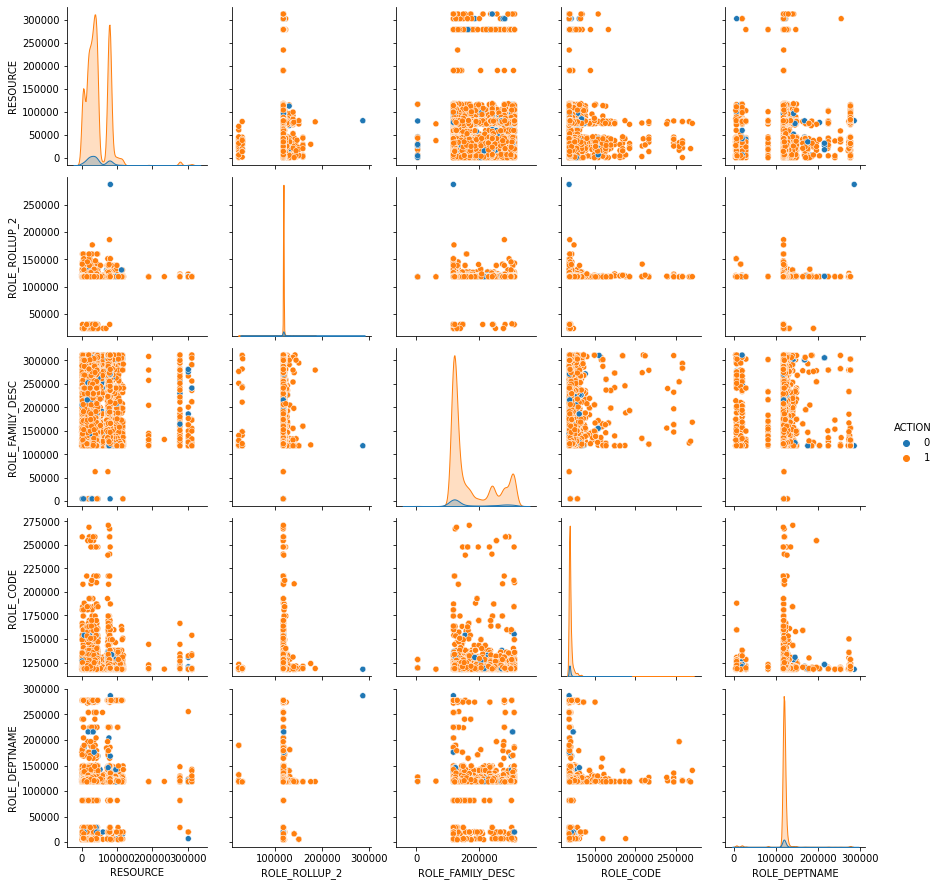

In [79]:
import seaborn as sns

sns.pairplot(train[['ACTION', 'RESOURCE','ROLE_ROLLUP_2','ROLE_FAMILY_DESC','ROLE_CODE',  'ROLE_DEPTNAME']],
             hue = 'ACTION'
            )

#### Observartion: ####

- We can see that there is no feature helps clear seperation between the both class.
- Severly imbalance: 94% of +ve sample and 6% of -ve sample 
    - Undersample: balance it we need to throw way approx 90% +ve sample. We are throwing away lot of information about the data and any model trained using such data will be highly bias.
    - Oversampleing: By looking at the result of the scatter plot to perform oversampleie will not make sence as -ve sample are very close to +ve samples.
- Different models approach to try:

    - There is no linear relation ship between the features. So model like Logistic Regression will not be helpfull.

    - K-NN: K-nn is about majority vote in it's proxmity region for the given K. Dominating class has advantage and not much of the the -ve sample are arround the +ve so selecting the K is problem. So result of K-NN will be bias of the +ve class label.

    - Naive Bayes is impaired by imbalance dataset. It impact the prior and likelyhood ratios.


### Check combination of data ###

In [6]:
target_col = 'ACTION'
col_use = [x for x in train.columns if not x in [target_col, 'ROLE_TITLE', 'MGR_ID']] 
#['ACTION', 'RESOURCE',  "ROLE_ROLLUP_2", 'ROLE_DEPTNAME','ROLE_FAMILY_DESC', 'ROLE_CODE']
col_use

['RESOURCE',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [7]:
train[col_use].nunique()

RESOURCE            7518
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

In [8]:
train[col_use] = train[col_use].applymap(str)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30391 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ACTION            30391 non-null  int64 
 1   RESOURCE          30391 non-null  object
 2   MGR_ID            30391 non-null  int64 
 3   ROLE_ROLLUP_1     30391 non-null  object
 4   ROLE_ROLLUP_2     30391 non-null  object
 5   ROLE_DEPTNAME     30391 non-null  object
 6   ROLE_TITLE        30391 non-null  int64 
 7   ROLE_FAMILY_DESC  30391 non-null  object
 8   ROLE_FAMILY       30391 non-null  object
 9   ROLE_CODE         30391 non-null  object
dtypes: int64(3), object(7)
memory usage: 2.6+ MB


In [ ]:
#i = 1
#for c1,c2 in permutations(col_use, 2):
#    print(f'{i}: {c1}-{c2}')
#    i += 1
#    print('='*50)

In [10]:
#col4train = col_use
#col4train.remove('RESOURCE')
new_cols = []
for c1,c2 in permutations(col_use, 2):
    
    name = "{}_{}".format(c1, c2)
    new_cols.append(name)
    train[name] = train[c1] + " " + train[c2]

print(f'Shape: {train.shape}')

train.head()

Shape: (30391, 52)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,...,ROLE_FAMILY_ROLE_ROLLUP_2,ROLE_FAMILY_ROLE_DEPTNAME,ROLE_FAMILY_ROLE_FAMILY_DESC,ROLE_FAMILY_ROLE_CODE,ROLE_CODE_RESOURCE,ROLE_CODE_ROLE_ROLLUP_1,ROLE_CODE_ROLE_ROLLUP_2,ROLE_CODE_ROLE_DEPTNAME,ROLE_CODE_ROLE_FAMILY_DESC,ROLE_CODE_ROLE_FAMILY
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908,...,290919 118300,290919 123472,290919 117906,290919 117908,117908 39353,117908 117961,117908 118300,117908 123472,117908 117906,117908 290919
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539,...,308574 118343,308574 123125,308574 118536,308574 118539,118539 17183,118539 117961,118539 118343,118539 123125,118539 118536,118539 308574
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880,...,19721 118220,19721 117884,19721 267952,19721 117880,117880 36724,117880 118219,117880 118220,117880 117884,117880 267952,117880 19721
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322,...,290919 118343,290919 119993,290919 240983,290919 118322,118322 36135,118322 117961,118322 118343,118322 119993,118322 240983,118322 290919
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325,...,19793 117930,19793 119569,19793 123932,19793 119325,119325 42680,119325 117929,119325 117930,119325 119569,119325 123932,119325 19793


In [11]:
nq = train[new_cols].nunique()
nq[nq.argsort()]

ROLE_ROLLUP_1_ROLE_ROLLUP_2         187
ROLE_ROLLUP_2_ROLE_ROLLUP_1         187
ROLE_CODE_ROLE_FAMILY               343
ROLE_FAMILY_ROLE_CODE               343
ROLE_FAMILY_ROLE_ROLLUP_1           750
ROLE_ROLLUP_1_ROLE_FAMILY           750
ROLE_FAMILY_ROLE_ROLLUP_2          1045
ROLE_ROLLUP_2_ROLE_FAMILY          1045
ROLE_DEPTNAME_ROLE_ROLLUP_1        1185
ROLE_ROLLUP_1_ROLE_DEPTNAME        1185
ROLE_ROLLUP_2_ROLE_DEPTNAME        1398
ROLE_DEPTNAME_ROLE_ROLLUP_2        1398
ROLE_ROLLUP_1_ROLE_CODE            1506
ROLE_CODE_ROLE_ROLLUP_1            1506
ROLE_FAMILY_ROLE_DEPTNAME          1613
ROLE_DEPTNAME_ROLE_FAMILY          1613
ROLE_CODE_ROLE_ROLLUP_2            2125
ROLE_ROLLUP_2_ROLE_CODE            2125
ROLE_FAMILY_ROLE_FAMILY_DESC       2586
ROLE_FAMILY_DESC_ROLE_FAMILY       2586
ROLE_CODE_ROLE_DEPTNAME            2946
ROLE_DEPTNAME_ROLE_CODE            2946
ROLE_CODE_ROLE_FAMILY_DESC         3013
ROLE_FAMILY_DESC_ROLE_CODE         3013
ROLE_FAMILY_DESC_ROLE_ROLLUP_1     3282


In [12]:
train.groupby(['ROLE_ROLLUP_1_ROLE_ROLLUP_2'])['ROLE_FAMILY_ROLE_CODE'].agg(lambda x: " ".join(list([str(y) for y in x])))

ROLE_ROLLUP_1_ROLE_ROLLUP_2
11146 118491     19721 118570 117887 117888 117887 117973 19721...
117876 117877    19721 117880 19721 118570 19721 247660 19793 1...
117882 117883    19721 117880 117887 117888 19721 117880 117887...
117882 123999    117887 118055 117887 118055 117887 118055 1178...
117887 118178    118638 119851 292795 118943 292795 118943 1219...
                                       ...                        
311178 119256                          118474 136061 118474 136061
4292 124335      119772 130062 119184 128095 119184 128095 1191...
4292 126095      117887 117973 117887 117973 119184 119194 1191...
5110 117954      19721 118570 19721 118570 118870 124539 19721 ...
91261 118026     118205 119964 290919 118322 290919 118279 2909...
Name: ROLE_FAMILY_ROLE_CODE, Length: 187, dtype: object

In [13]:
train.groupby(['ROLE_ROLLUP_1'])['ROLE_DEPTNAME'].agg(lambda x: " ".join(list([str(y) for y in x])))

ROLE_ROLLUP_1
11146     117941 117884 118599 117920 117884 117920 1179...
117876    117878 117878 117878 118810 117878 118810 1188...
117882    117884 117884 117884 117884 118552 118552 1178...
117887    118575 117945 117945 119796 135245 117945 1183...
117890    117878 117878 117878 117878 117878 117878 1178...
                                ...                        
247952    117878 117878 117878 117878 117878 117878 1178...
311178                                        118471 118471
4292      274241 118378 118378 118378 118378 118378 1183...
5110      117895 117895 122672 117895 122672 117895 1226...
91261     118202 119507 118202 118202 119362 119507 1182...
Name: ROLE_DEPTNAME, Length: 128, dtype: object

Observation:
* Combination of some feature have high cardinality. Combining such catagories together reduces the number of observation per group value in the resulting features encoding. It will not generalize well and the model will overfit.
* KFoldTargetEncoding: Will not work in case of "RESOURCE"  as 89% of records has only 1 data points. In this case most of the time in each fold the value will be NaN and if we replace NaN to global mean of "ACTION" we will be encoding most of the value with global mean which is no different the standard target encoding which will not be helpful. Approx 85% of "RESOURCE" will have the same probality/mean "ACTION"value. KFoldTE is helpfull for less cardinal feature or if in each fold will have most of group value in the valid dataset. Since Fold are random it not possible. 
    - Solution:
        - Instead of KFold we can use StrafiedKFold so that it ensure that in each Kold we have same proportion of +ve ad -ve sample. 
        - Instead of replacing the NaN with the Global mean, will compute the mean of target("ACTION") in the Fold train dataset(X_tr) of the KFold split and replace the missing NaN in validation dataset(X_val) of the KFold split with that mean.
* Frequency/Count Encoding: This might be helpfull for those feature that occure least in the dataset for some particular "RESOURCE".
* When groupby column and join value of the other feature for that group we see repeation of the feature values. 
    If we think, values of feature's are set of word (Corpus) and when we join based on all the possible values for a group we get a string that can be thought of a document.  